<a href="https://colab.research.google.com/github/Jagan-Dattu/Machine-Learning-Based-project/blob/main/Water_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving water_potability.csv to water_potability (1).csv
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000

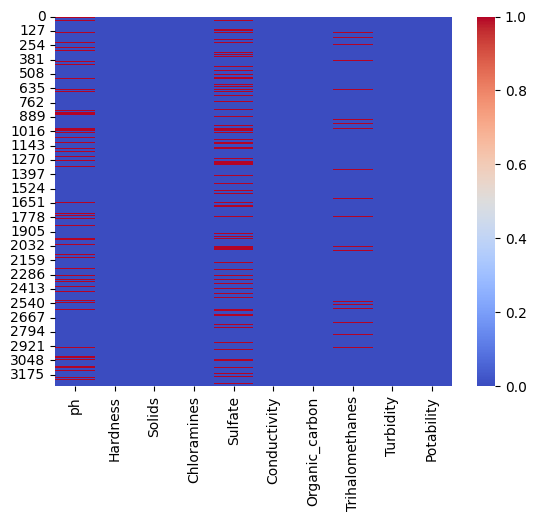

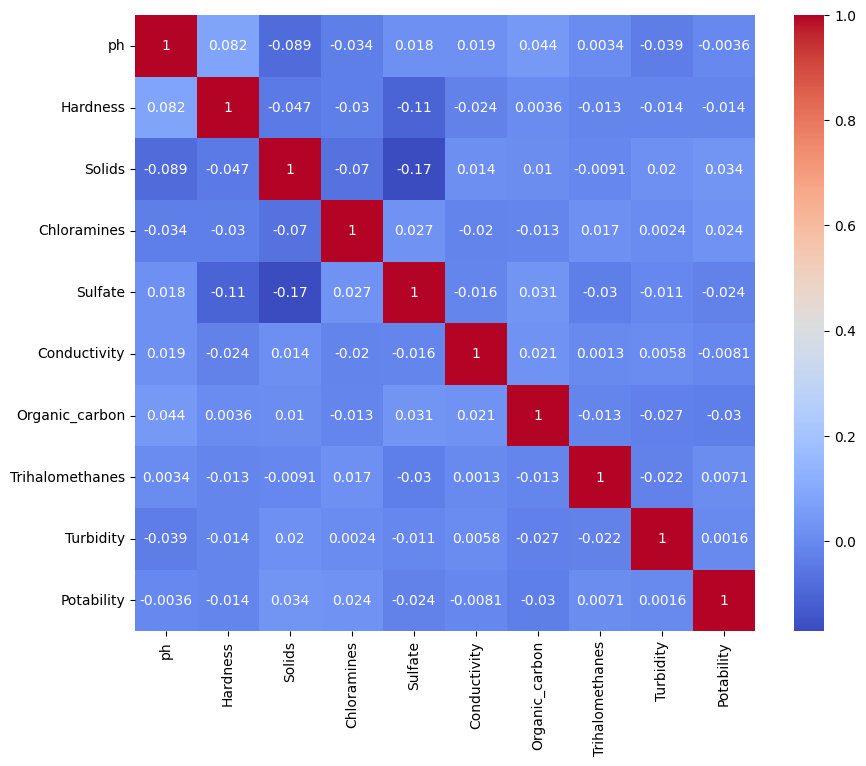

Potability
0    1998
1    1278
Name: count, dtype: int64


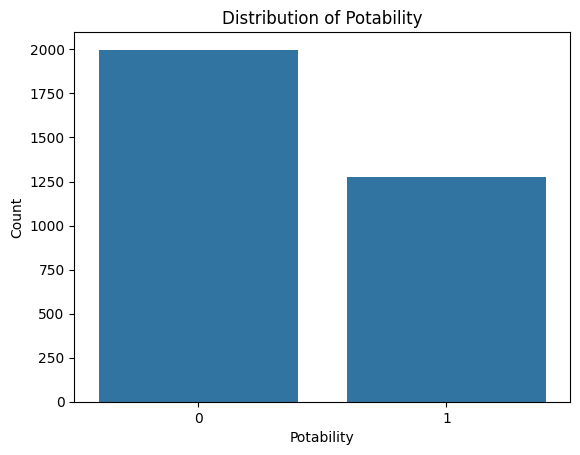

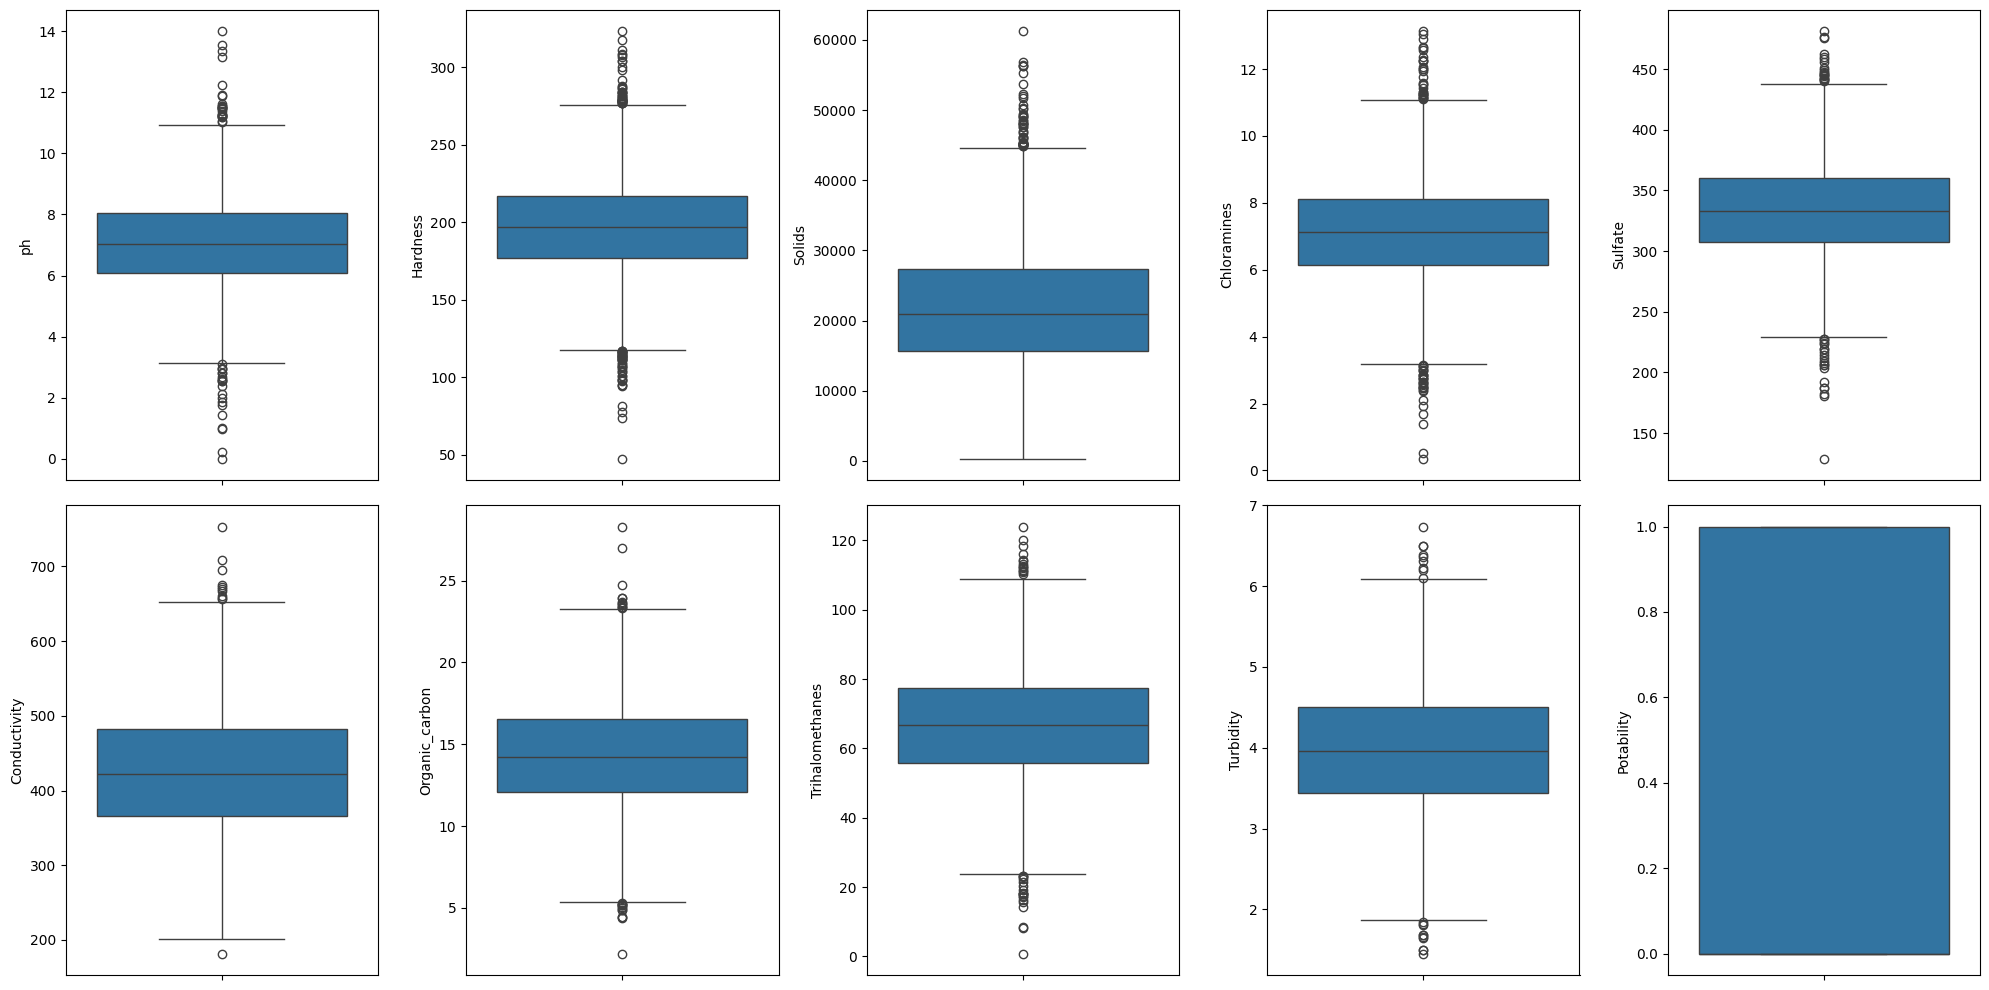

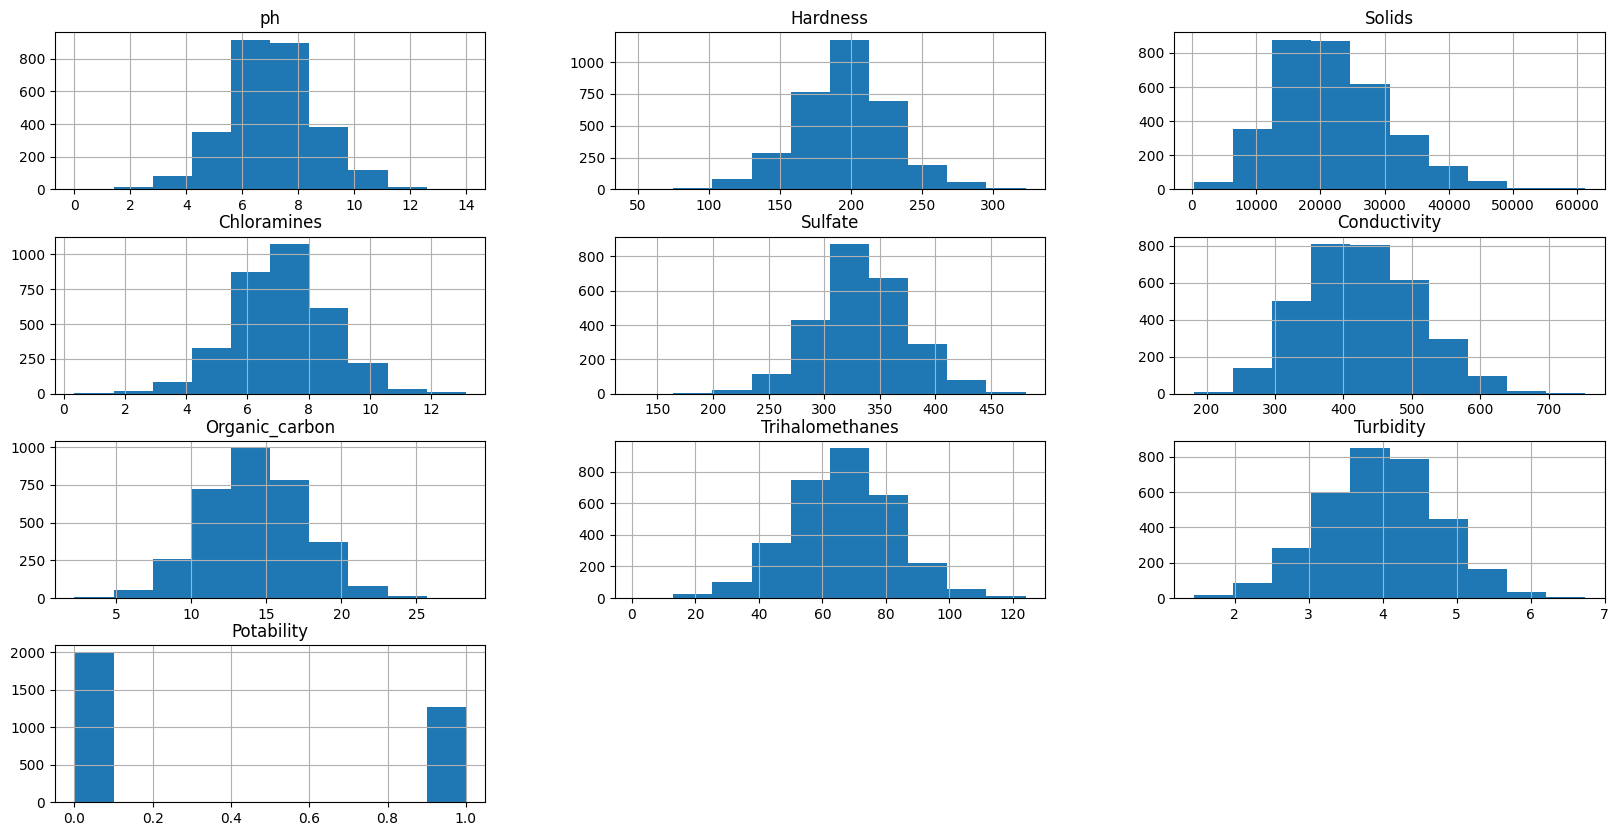

Missing values after filling: 0

ðŸ“Œ **Before Hyperparameter Optimization**

ðŸ”¹ Model: Logistic Regression
Accuracy: 0.5684
RÂ² Score: -0.7311
MSE: 0.4316
RMSE: 0.6569
MAE: 0.4316
              precision    recall  f1-score   support

           0       0.56      0.87      0.68       400
           1       0.62      0.24      0.34       360

    accuracy                           0.57       760
   macro avg       0.59      0.55      0.51       760
weighted avg       0.59      0.57      0.52       760


ðŸ”¹ Model: Decision Tree
Accuracy: 0.6092
RÂ² Score: -0.5675
MSE: 0.3908
RMSE: 0.6251
MAE: 0.3908
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       400
           1       0.59      0.60      0.59       360

    accuracy                           0.61       760
   macro avg       0.61      0.61      0.61       760
weighted avg       0.61      0.61      0.61       760


ðŸ”¹ Model: Random Forest
Accuracy: 0.6789
RÂ² Score: -0.2878


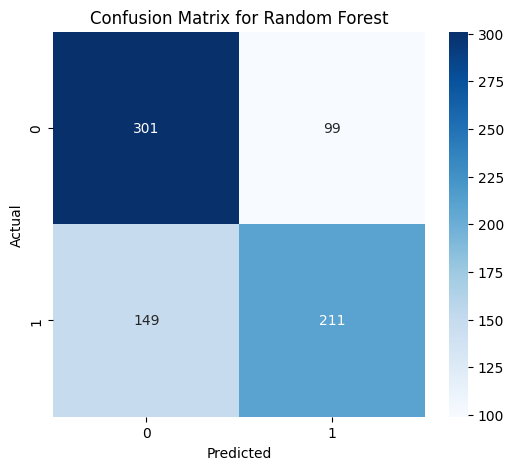

ðŸš€ ROC-AUC Score for Random Forest: 0.7178


In [ ]:
# ---------------------- IMPORT LIBRARIES ---------------------- #
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from google.colab import files
uploaded = files.upload()
# ---------------------- LOAD DATASET ---------------------- #
df = pd.read_csv("water_potability.csv")

# ---------------------- DATA EXPLORATION ---------------------- #
print(df.head())
print(df.describe())
print(df.info())
print(df.nunique())
print(df.isnull().sum())

# Heatmap for missing values
sns.heatmap(df.isnull(), cmap="coolwarm")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Class Distribution
x = df.Potability.value_counts()
print(x)
sns.barplot(x=x.index, y=x.values)
plt.xlabel("Potability")
plt.ylabel("Count")
plt.title("Distribution of Potability")
plt.show()

# Boxplots for Outlier Detection
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()
for col in df.columns:
    sns.boxplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout()
plt.show()

# Histograms & Distributions
df.hist(figsize=(20, 10))
plt.show()



# ---------------------- HANDLE MISSING VALUES ---------------------- #
df.fillna(df.median(), inplace=True)
print("Missing values after filling:", df.isnull().sum().sum())

# ---------------------- DEFINE FEATURES & TARGET VARIABLE ---------------------- #
X = df.drop("Potability", axis=1)
y = df["Potability"]

# ---------------------- CREATE POLYNOMIAL FEATURES ---------------------- #
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# ---------------------- APPLY PCA ---------------------- #
pca = PCA(n_components=6)  # Reduce dimensions to 6
X_pca = pca.fit_transform(X_poly)

# ---------------------- FEATURE SCALING ---------------------- #
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# ---------------------- HANDLE CLASS IMBALANCE USING SMOTE ---------------------- #
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# ---------------------- SPLIT DATA ---------------------- #
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# ---------------------- DEFINE MODELS ---------------------- #
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(eval_metric="logloss")
}

# ---------------------- TRAIN & EVALUATE MODELS BEFORE OPTIMIZATION ---------------------- #
model_accuracies = {}
model_errors = {}

print("\n **Before Hyperparameter Optimization**")
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Error Metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    model_accuracies[name] = [accuracy]
    model_errors[name] = {"RÂ²": r2, "MSE": mse, "RMSE": rmse, "MAE": mae}

    print(f"\n Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"RÂ² Score: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(classification_report(y_test, y_pred))

# ---------------------- HYPERPARAMETER TUNING ---------------------- #
tuned_models = {}

param_grid = {
    "Logistic Regression": {"C": np.logspace(-4, 4, 20)},
    "Decision Tree": {"max_depth": range(5, 30, 5), "min_samples_split": range(2, 10, 2)},
    "Random Forest": {"n_estimators": [100, 300, 500], "max_depth": [10, 20, 30], "min_samples_split": [2, 5, 10]},
    "KNeighbors": {"n_neighbors": range(3, 10), "weights": ["uniform", "distance"]},
    "SVM": {"C": np.logspace(-2, 2, 10), "kernel": ["linear", "rbf"]},
    "XGBoost": {"n_estimators": [100, 300, 500], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [6, 10, 15]}
}

for name, model in models.items():
    search = RandomizedSearchCV(model, param_grid[name], n_iter=5, cv=3, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    tuned_models[name] = search.best_estimator_

# ---------------------- COMPARE MODELS AFTER OPTIMIZATION ---------------------- #
print("\n **After Hyperparameter Optimization**")
for name, model in tuned_models.items():
    y_pred_tuned = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_tuned)
    model_accuracies[name].append(accuracy)

    print(f"\n Best Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred_tuned))


# ---------------------- COMPARE ACCURACIES ---------------------- #
print("\n *Model Accuracy Comparison* ")
df_results = pd.DataFrame(model_accuracies, index=["Before Optimization", "After Optimization"])
print(df_results.T)

# ---------------------- CONFUSION MATRIX & ROC SCORE FOR BEST MODEL ---------------------- #
best_model_name = max(model_accuracies, key=lambda x: model_accuracies[x][1])
best_model = tuned_models[best_model_name]

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap="Blues")
plt.title(f"Confusion Matrix for {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_best = best_model.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, y_prob_best)
print(f" ROC-AUC Score for {best_model_name}: {roc_score:.4f}")
